# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [50]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2023-03-13 02:03:55--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat.1’

notMNIST_small.mat. 100%[===================>] 112.14M  56.6MB/s    in 2.0s    

2023-03-13 02:03:57 (56.6 MB/s) - ‘notMNIST_small.mat.1’ saved [117586976/117586976]



In [51]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [52]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

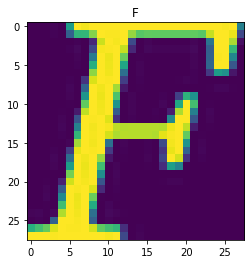

In [53]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

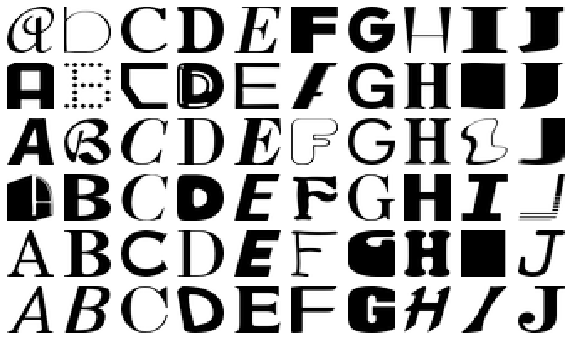

In [54]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [55]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [56]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Optimizer를 따로 선언해서 사용
3. Dropout을 0.2 정도로 활용해볼 것
4. 초기값은 default로
5. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
6. Early stopping도 활용해볼 것

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model

In [58]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [59]:
x_train.shape

(14979, 28, 28, 1)

In [60]:
# 1. 세션 초기화
keras.backend.clear_session()

# 2. 모델 엮기
il = keras.layers.Input(shape=(28, 28, 1))
fl = keras.layers.Flatten()(il)
hl = keras.layers.Dense(512, activation='relu')(fl)
bn = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dense(256, activation='relu')(bn)
bn = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dense(128, activation='relu')(bn)
bn = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bn)
ol = keras.layers.Dense(10, activation='softmax')(dl)

model = keras.models.Model(il, ol)

# 3. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


# 4. 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

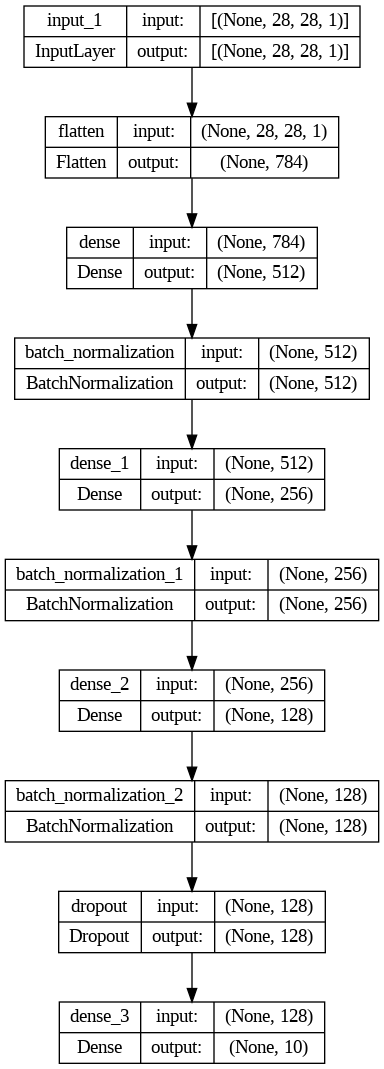

In [61]:
plot_model(model, show_shapes=True)

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0,
    restore_best_weights=True,
    verbose=1
)

In [64]:
history = model.fit(x_train, y_train_c, validation_split=0.2,
                    epochs=10000, callbacks=[es])

Epoch 1/10000
375/375 [==============================] - 5s 7ms/step - loss: 0.5223 - accuracy: 0.8460 - val_loss: 0.4403 - val_accuracy: 0.8718
Epoch 2/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.3428 - accuracy: 0.8988 - val_loss: 0.4426 - val_accuracy: 0.8892
Epoch 3/10000
375/375 [==============================] - 3s 7ms/step - loss: 0.2963 - accuracy: 0.9099 - val_loss: 0.4032 - val_accuracy: 0.8929
Epoch 4/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2654 - accuracy: 0.9195 - val_loss: 0.3978 - val_accuracy: 0.8902
Epoch 5/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2309 - accuracy: 0.9249 - val_loss: 0.4095 - val_accuracy: 0.8902
Epoch 6/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2191 - accuracy: 0.9337 - val_loss: 0.4058 - val_accuracy: 0.8945
Epoch 7/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.1967 - accuracy: 0.9369 - val_loss: 0.4538 - val_ac

In [65]:
y_pred = model.predict(x_test, verbose=0)

In [66]:
y_pred.argmax(axis=1)[:10]

array([9, 7, 3, 5, 0, 2, 3, 4, 5, 8])

In [67]:
y_test[:10]

array([9, 7, 3, 5, 0, 2, 3, 4, 5, 8], dtype=int32)

In [68]:
model.evaluate(x_test, y_test_c)

118/118 [==============================] - 0s 3ms/step - loss: 0.3414 - accuracy: 0.9004


[0.34136053919792175, 0.9004005193710327]

In [69]:
#################
# 매번 dropout 해보기
# 1. 세션 초기화
keras.backend.clear_session()

# 2. 모델 엮기
il = keras.layers.Input(shape=(28, 28, 1))
fl = keras.layers.Flatten()(il)
hl = keras.layers.Dense(512, activation='relu')(fl)
bn = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bn)

hl = keras.layers.Dense(256, activation='relu')(bn)
bn = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bn)

hl = keras.layers.Dense(128, activation='relu')(bn)
bn = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bn)

ol = keras.layers.Dense(10, activation='softmax')(dl)

model = keras.models.Model(il, ol)

# 3. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


# 4. 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

In [70]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0,
    restore_best_weights=True,
    verbose=1
)

history2 = model.fit(x_train, y_train_c, validation_split=0.2,
                    epochs=10000, callbacks=[es])

Epoch 1/10000
375/375 [==============================] - 5s 6ms/step - loss: 0.5158 - accuracy: 0.8518 - val_loss: 0.4442 - val_accuracy: 0.8768
Epoch 2/10000
375/375 [==============================] - 3s 7ms/step - loss: 0.3477 - accuracy: 0.8954 - val_loss: 0.4404 - val_accuracy: 0.8738
Epoch 3/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2940 - accuracy: 0.9135 - val_loss: 0.4428 - val_accuracy: 0.8822
Epoch 4/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2552 - accuracy: 0.9203 - val_loss: 0.3577 - val_accuracy: 0.8989
Epoch 5/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2286 - accuracy: 0.9297 - val_loss: 0.4021 - val_accuracy: 0.8929
Epoch 6/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.2125 - accuracy: 0.9347 - val_loss: 0.3901 - val_accuracy: 0.9019
Epoch 7/10000
375/375 [==============================] - 2s 6ms/step - loss: 0.1948 - accuracy: 0.9372 - val_loss: 0.4450 - val_ac

In [71]:
y_pred = model.predict(x_test, verbose=0)
print(y_pred.argmax(axis=1)[:10])
print(y_test[:10])
model.evaluate(x_test, y_test_c)

[9 7 3 5 0 2 3 4 5 8]
[9 7 3 5 0 2 3 4 5 8]
118/118 [==============================] - 0s 3ms/step - loss: 0.3130 - accuracy: 0.9100


[0.3130412995815277, 0.9100133776664734]

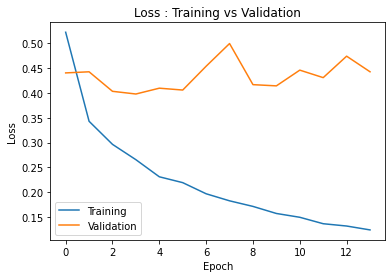

In [72]:
import matplotlib.pyplot as plt

if not isinstance(history, dict):
    history = history.history

plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

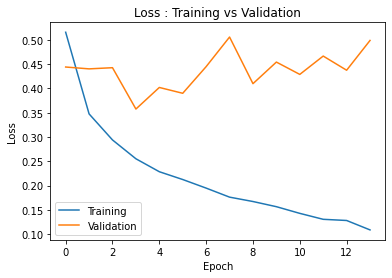

In [73]:
import matplotlib.pyplot as plt

if not isinstance(history2, dict):
    history2 = history2.history

plt.subplot(2, 1, 1)
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot()
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()